In [1]:

import matplotlib as mpl
import matplotlib.pyplot as plt

from feature_selection import *
from log_class import log_recorder
def load_log_and_qps(log_file, ground_truth_csv):
    # load the data
    return log_recorder(log_file,ground_truth_csv)

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

LOG_DIR = "log_files/StorageMaterial.NVMeSSD/12CPU/64MB/"
report_csv = "report.csv_1180"
LOG_file = "LOG_1180"

data_set = load_log_and_qps(LOG_DIR+LOG_file, LOG_DIR+report_csv)

,secs_elapsed,interval_qps,change_points
0,1.0,415590.0,1.0
1,2.0,409610.0,1.0
2,3.0,411995.0,1.0
3,4.0,408480.0,1.0
4,5.0,410381.0,1.0
...,...,...,...
1179,1196.0,320450.0,1.0
1180,1197.0,329779.0,1.0
1181,1198.0,329858.0,1.0
1182,1199.0,315418.0,1.0


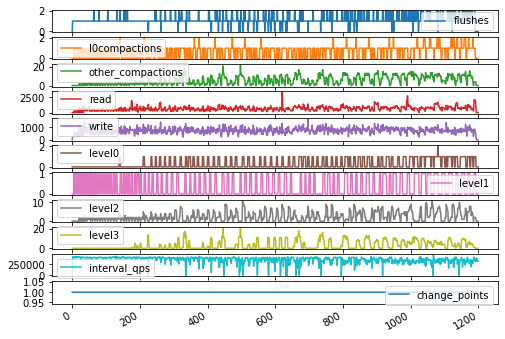

In [24]:
bucket_df = vectorize_by_compaction_output_level(data_set)

def combine_vector_with_qps(bucket_df, qps_df):
    # since qps_df starts from sec 1, add the first line, [0,0,0]
    id_df = pd.DataFrame(list(range(bucket_df.shape[0])), columns=["secs_elapsed"])
    id_df = id_df.merge(qps_df,how="left",on="secs_elapsed")
    id_df['interval_qps'] = id_df['interval_qps'].fillna(0)
    id_df['change_points'] = id_df['change_points'].fillna(1)
    id_df = id_df[["interval_qps","change_points"]]
    result_bf = pd.concat([bucket_df,id_df],axis=1)
    return result_bf

bucket_df = combine_vector_with_qps(bucket_df,data_set.qps_df)
bucket_df.plot(subplots=True)

In [3]:
data_set.compaction_df

,start_time,input_data_size,job,compaction_reason,end_time,compaction_time_micros,compaction_time_cpu_micros,total_output_size,lsm_state,output_level
0,8150639,338058752,5,LevelL0FilesNum,9337125,1180165,695913,336606433,"[0, 3, 0, 0, 0, 0, 0]",1
1,15773935,538873376,10,LevelL0FilesNum,17589141,1807771,1172213,535551146,"[0, 4, 1, 0, 0, 0, 0]",1
2,23333544,601977956,16,LevelL0FilesNum,25490423,2148877,1315578,598215509,"[0, 5, 3, 0, 0, 0, 0]",1
3,25537670,271562323,19,LevelMaxLevelSize,26647149,1100388,552979,270467067,"[1, 2, 6, 0, 0, 0, 0]",2
4,26666509,406287177,21,LevelMaxLevelSize,27842969,1169276,804665,405171649,"[1, 1, 7, 0, 0, 0, 0]",2
...,...,...,...,...,...,...,...,...,...,...
706,1189709888,814755821,1289,LevelMaxLevelSize,1193810480,4084361,2040571,765499118,"[5, 3, 31, 214, 24, 0, 0]",3
707,1193971415,871605353,1292,LevelL0FilesNum,1196911982,2924897,1972357,863583039,"[1, 7, 31, 214, 24, 0, 0]",1
708,1196973019,151126392,1294,LevelMaxLevelSize,1197441498,455372,317974,149238155,"[1, 6, 30, 214, 24, 0, 0]",2
709,1197441571,522990474,1296,LevelMaxLevelSize,1199138997,1682061,1074045,516618274,"[2, 5, 30, 214, 24, 0, 0]",2


In [12]:
time_slice = 1000000
def vectorize(log_and_qps, time_slice):
    ms_to_second = 1000000
    max_file_level = 7
    feature_columns = ["flushes", "l0compactions",
                       "other_compactions", "read", "write"]
    file_counter_list = ["level"+str(x) for x in range(max_file_level)]
    # file_counter_list = []
    feature_columns.extend(file_counter_list)

    print(feature_columns)
    switch_ratio = ms_to_second / time_slice

    real_time_speed = log_and_qps.qps_df

    elasped_time = int(real_time_speed.tail(1)["secs_elapsed"] * switch_ratio)

    bucket = np.zeros([elasped_time, len(feature_columns)], dtype=float)
    for index, flush_job in log_and_qps.flush_df.iterrows():
        # bytes/ms , equals to MB/sec
        flush_speed = round(
            flush_job["flush_size"] / (flush_job["end_time"] - flush_job["start_time"]), 2)
        start_index = int(flush_job["start_time"] / time_slice)
        end_index = int(flush_job["end_time"] / time_slice) + 1
        # the tail part is not accurant
        if start_index >= len(bucket) - 10 or end_index >= len(bucket) - 5:
            break
        for element in bucket[start_index:end_index]:
            element[0] += 1
            element[4] += flush_speed

    for index, compaction_job in log_and_qps.compaction_df.iterrows():
        compaction_read_speed = round(compaction_job["input_data_size"] / (
            compaction_job["compaction_time_micros"]), 2)  # bytes/ms , equals to MB/sec
        compaction_write_speed = round(compaction_job["total_output_size"] / (
            compaction_job["compaction_time_micros"]), 2)  # bytes/ms , equals to MB/sec
        start_index = int(compaction_job["start_time"] / time_slice)
        end_index = int(compaction_job["end_time"] / time_slice) + 1
        lsm_state = compaction_job["lsm_state"]

        # the tail part is not accurant
        if start_index >= len(bucket) - 10 or end_index >= len(bucket) - 5:
            break
        for element in bucket[start_index:end_index]:
            element[0] += 0
            if compaction_job["compaction_reason"] == "LevelL0FilesNum":
                element[1] += 1
            else:
                element[2] += 1
            element[3] += compaction_read_speed
            element[4] += compaction_write_speed
            for level in range(len(file_counter_list)):
                # print(compaction_job["output_level"])
                if compaction_job["output_level"] == level:
                    element[5 + level] += 1
                # print(level)
    # compute the mean of the lsm state

    return pd.DataFrame(bucket, columns=feature_columns)

bucket_df = vectorize(data_set,time_slice)

bucket_df["qps"] = data_set.qps_df["interval_qps"]

read = bucket_df["read"]
MAX_READ = 2000
bad_read = read >= MAX_READ
read[bad_read] = MAX_READ
plot_features = bucket_df[bucket_df.columns]

_ = plot_features.plot(subplots=True)

plt.savefig("compaction_distribution_by_level.pdf",bbox_inches="tight")
plt.clf()

['flushes', 'l0compactions', 'other_compactions', 'read', 'write', 'level0', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6']


<Figure size 576x432 with 0 Axes>

['qps_in_0_sec', 'qps_in_1_sec', 'qps_in_2_sec', 'qps_in_3_sec', 'qps_in_4_sec', 'qps_in_5_sec', 'qps_in_6_sec', 'qps_in_7_sec', 'qps_in_8_sec', 'qps_in_9_sec']


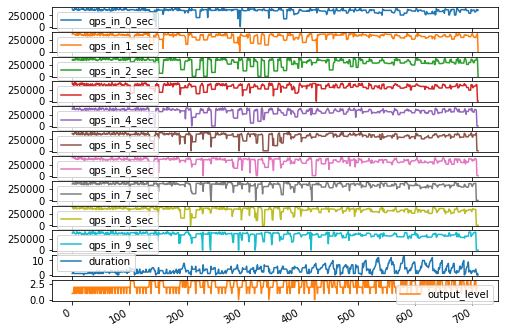

In [58]:
def qps_after_compaction(log_and_qps,time_slice,time_window=10):
    ms_to_second = 1000000
    feature_columns=["qps_in_%d_sec"%x for x in range(time_window)]
    print(feature_columns)
    feature_columns.append("duration")
    feature_columns.append("output_level")

    result_df = pd.DataFrame(columns=feature_columns)

    for index, compaction_job in log_and_qps.compaction_df.iterrows():
        start_time_sec = int(compaction_job["start_time"] / time_slice)
        duration = int((compaction_job["end_time"]-compaction_job["start_time"])/time_slice)
        row = []
        for i in range(time_window):
            qps_value = log_and_qps.qps_df[
                           log_and_qps.qps_df["secs_elapsed"] == start_time_sec+i]
            if qps_value.empty:
                row.append(0)
            else:
                row.append(qps_value["interval_qps"].item())
        row.append(duration)
        row.append(compaction_job["output_level"])
        result_df.loc[index] = row
    return result_df

df = qps_after_compaction(data_set,time_slice)


_ = df.plot(subplots=True)

<AxesSubplot:>

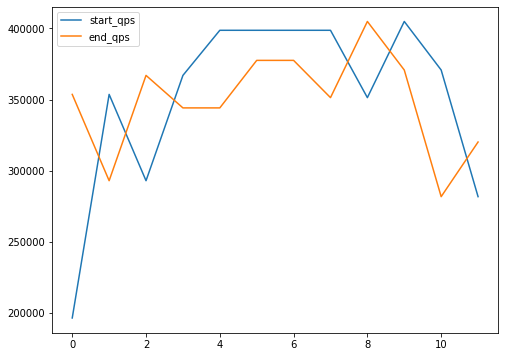

In [178]:
# let's check the compaction gap, and the qps influence brought by it
max_qps = data_set.qps_df.max()["interval_qps"]

threshold = max_qps*0.5
window_size = 10

low_qps_moments = data_set.qps_df[data_set.qps_df["interval_qps"] <= threshold]


low_qps_moments
first_spike = low_qps_moments.iloc[-1]

compaction_around_first_spike=[]
low_qps_df = data_set.compaction_df[abs((data_set.compaction_df["start_time"] / time_slice) - first_spike["secs_elapsed"]) <=window_size]

sorted_low_qps_df = low_qps_df.sort_values(by="job")[["job","lsm_state"]]
start_time_seq = (low_qps_df["start_time"] / time_slice).astype("int64").values.tolist()
end_time_seq = (low_qps_df["end_time"] / time_slice).astype("int64").values.tolist()
start_qps_seq = data_set.qps_df["interval_qps"][start_time_seq]
end_qps_seq = data_set.qps_df["interval_qps"][end_time_seq]

qps_list = pd.DataFrame({
    "start_qps":start_qps_seq.values.tolist(),
    "end_qps":end_qps_seq.values.tolist()
})
sorted_low_qps_df = sorted_low_qps_df.reset_index().join(qps_list)

sorted_low_qps_df[["start_qps","end_qps"]].plot()

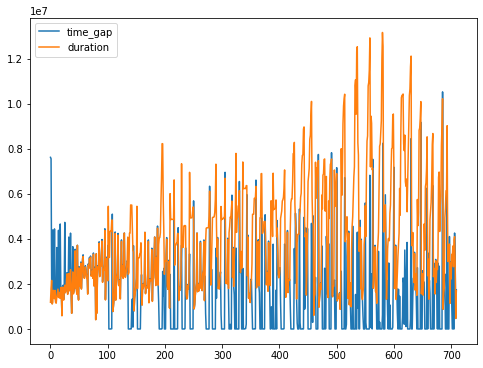

In [191]:
time_gap = []
duration = []
for index, compaction_job in data_set.compaction_df.iterrows():
    if index == data_set.compaction_df.shape[0]-1:
        break
    time_gap.append( data_set.compaction_df["start_time"][index+1] - compaction_job["start_time"])
    duration.append(compaction_job["end_time"]-compaction_job["start_time"])
plt.plot(time_gap,label="time_gap")
plt.plot(duration,label="duration")
plt.legend()
# plt.clf()


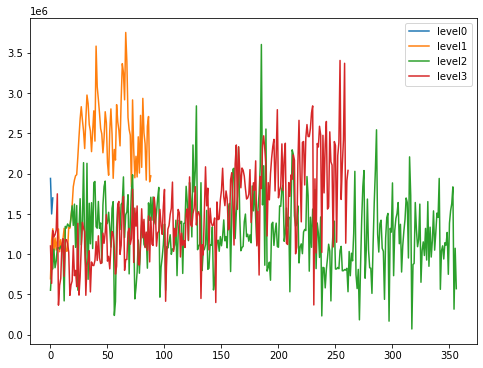

In [203]:
plt.clf()

dfs = []

for i in range(4):
    tmp = data_set.compaction_df[data_set.compaction_df["output_level"]==i]
    dfs.append(tmp.reset_index())
i = 0
for test_df in dfs:
    plt.plot(test_df["compaction_time_cpu_micros"].values.tolist(),label="level%d"%i)
    i+=1
plt.legend()

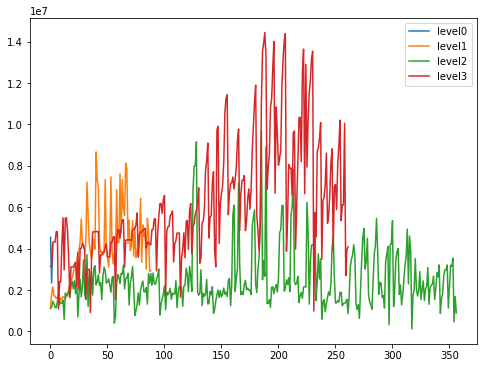

In [205]:
plt.clf()

i = 0
for test_df in dfs:
    plt.plot(test_df["compaction_time_micros"].values.tolist(),label="level%d"%i)
    i+=1
plt.legend()